## PROGRAMMING KNN IN SPARK

Starting the Spark context

In [1]:
import sys
import os
import os.path

SPARK_HOME = """/home/alessandro/Downloads/spark-2.1.0-bin-hadoop2.7""" 

sys.path.append(os.path.join(SPARK_HOME, "python", "lib", "py4j-0.10.4-src.zip")) #BEWARE WITH py4j version!!
sys.path.append(os.path.join(SPARK_HOME, "python", "lib", "pyspark.zip"))
os.environ["SPARK_HOME"] = SPARK_HOME

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("KNN with k=1 and k=2") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
    
sc = spark.sparkContext

In [57]:
#Imports
%matplotlib inline
from pyspark.mllib.regression import LabeledPoint
import numpy as np
import matplotlib.pyplot as plt

Convert the Scikit-learn Iris dataset into a Spark RDD

In [131]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data            # Input attributes
y = iris.target          # Label
# zip is used so that each instance is a tuble of (label, input attributes). 
# This will make life easier later
# Note: zip([1,2,3], ["a","b","c"]) => [(1, 'a'), (2, 'b'), (3, 'c')]
data = zip(y,X) 

The RDD is split into 4 partitions

In [132]:
data_rdd = sc.parallelize(data,4)

Convert the rdd into a LabeledPoint RDD

In [133]:
data_rdd = data_rdd.map(lambda x: LabeledPoint(x[0], x[1]))

In [134]:
data_rdd.take(2)

[LabeledPoint(0.0, [5.1,3.5,1.4,0.2]), LabeledPoint(0.0, [4.9,3.0,1.4,0.2])]

Let's classify test instance p = [5.1,3.5,1.4,0.2]

In [135]:
p = [5.3,3.2,1.6,0.1]

**You start here: (0.5 points)** Write Spark code that prints the class of the closest data_rdd instance to p. The solution is actually quite short, but you can use as many cells as you need. Try your code to be as efficient as possible. **Important:** You are not allowed to sort the RDD (i.e. you cannot use takeOrdered(), top(), sortByKey(), or similar).

<b> KNN </b>

To identify the class of the closest data_rdd instance to p, first a KNN must be trained. 

The First thing to do is to separate the input attributes from labels.

In [136]:
#Separating x features
X_rdd = data_rdd.map(lambda x: x.features)

#Seperating y label
y_rdd = data_rdd.map(lambda x: x.label)

In [137]:
print(X_rdd.take(2))
print(y_rdd.take(2))

[DenseVector([5.1, 3.5, 1.4, 0.2]), DenseVector([4.9, 3.0, 1.4, 0.2])]
[0.0, 0.0]


<b> First Step </b>

First, the number of required clusters is initialized to 3 and the initial prototypes are initialized to three random instances

In [138]:
K=3
kPrototypes = X_rdd.takeSample(False, K, 1)
kPrototypes

[DenseVector([6.4, 2.8, 5.6, 2.2]),
 DenseVector([5.5, 2.5, 4.0, 1.3]),
 DenseVector([5.2, 4.1, 1.5, 0.1])]

<b> Plot </b>

Lets plot where the prototypes are

In [139]:
def plotPrototypes():
    plt.scatter(X[:, 0], X[:, 1])
    # kPrototypes is transformed into a numpy matrix (attributes in the columns, instances in the rows)
    kProtos = np.array(map(lambda x: x, np.array(kPrototypes)))
    plt.scatter(kProtos[:,0], kProtos[:,1], color='red', s=200)

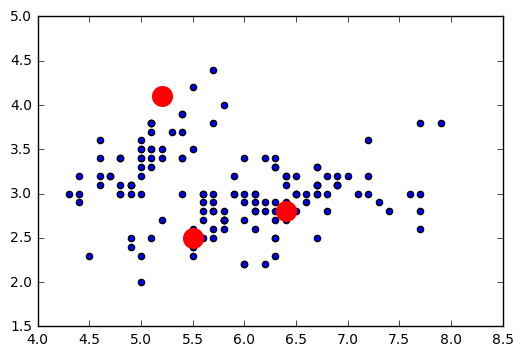

In [87]:
plotPrototypes()

<b> Second and Third Step </b>

Step 2 of the K-means algorithm is "2.Assign each instance xi to its closest prototype". Function closestPrototype is defined for this purpose. 

Afterwards, Assign each instance xi to its closest prototype

Step 3.(REDUCE) 
Update the location of prototypes kj as the average of the instances xi assigned to each cluster.

This is run until the cluster do not change. 

In [140]:
#Define Function to find closest group
def closestPrototype(x):
    distances = map(lambda kp: np.linalg.norm(x-kp), kPrototypes)
    distances = np.array(distances)
    return(np.ndarray.argmin(distances))

In [143]:
i = 0

while (True):
    # 2. (MAP) Assign each instance xi to its closest prototype 
    closest_rdd = X_rdd.map(lambda x: (closestPrototype(x), (x,1)))
    # 3. (REDUCE) Update the location of prototypes kj as the average of the instances xi assigned to each cluster.
    oldK = kPrototypes 
    #Get current Norm Distance
    diff1 = map(lambda kp: np.linalg.norm(oldK-kp), kPrototypes)
    
    #Move the prototypes
    kPrototypes = closest_rdd.reduceByKey(lambda p1, p2: (p1[0] + p2[0], p1[1] + p2[1])).collect()
    kPrototypes = map(lambda (k,(summation, n)): summation / n, kPrototypes)
    
    #Get updated Norm Distance
    diff2 = map(lambda kp: np.linalg.norm(oldK-kp), kPrototypes)
    
    #Subtract Vectors
    diff = np.subtract(diff1, diff2)
    #Check Threshold
    boolDiff = map(lambda e: e < 0.001, diff)
    
    #In case it does not converge
    i = i + 1
    
    #If it converged, exit
    if ( all(boolDiff) or i > 100 ):
        break
        
print "End Training Model"

End Training Model


Now with a trained KNN we can determine the class of the closest data_rdd instance to p. 

In [155]:
print p

closestClass = closestPrototype(p)

print "The classes are 0, 1 and 2"
print "Closest class of p is {}".format(closestClass)

[5.3, 3.2, 1.6, 0.1]
The classes are 0, 1 and 2
Closest class of p is 2


**You may continue here: (0.5 points)** Now, write Spark code that prints the class of the **second** closest data_rdd instance to p. Again, sorting the RDD is not allowed.

In [165]:

#Function to find the n-th class closest to x
def closestPrototype2(x, n):
    if (n > K):
        print "Error: The n-th class cannot be large thant the number of K Groups"
        return None 
    
    # First, 
    distances = map(lambda kp: np.linalg.norm(x-kp), kPrototypes)
    distances = np.array(distances)
    value     = np.partition(distances, K-1)[n-1]
    element   = np.where(distances == value)[0]
    return (element[0])


print "The classes are 0, 1 and 2"
closestClass = closestPrototype2(p, 2)
print "The n-th Closest class of p is {}".format(closestClass)

The classes are 0, 1 and 2
The n-th Closest class of p is 1


In [ ]:
sc.stop()